# Example Usage

It's always a good habit to check the card availability first

In [1]:
scan_output = !xbutil scan

In [2]:
print(scan_output[-2])
print(scan_output[-1])

[0]mgmt:[65:00.1]:0x5004:0x000e:[xclmgmt:2018.2.2:25857]
[0]user:[65:00.0]:0x5005:0x000e:[xocl_xdma:2018.2.8:128]


In [3]:
if "*" in scan_output[-2] or "*" in scan_output[-1]:
    print("Your card is not ready")
else:
    print("Your card is good to go")

Your card is good to go


### Installation

First make sure you have XRT installed, then just do `pip install xrt`

### Getting Started

First import the xrt core library

use `from xrt.core import hal` for hardware

use `from xrt.core import sw_emu_hal as hal` for software emulation

use `from xrt.core import hw_emu_hal as hal` for hardware emulation

###### Note:

For some reason, dynamic loading is determined at OpenCL level. Although both emulation and hardware implement the same abstraction layer, it is not switchable at this layer. At the same time, static linking is also troublesome because emulation is missing some APIs.

In [4]:
from xrt.core import hal

In [5]:
import numpy as np

In [6]:
%matplotlib inline
from tqdm import tnrange, tqdm_notebook
from time import sleep
import time
import matplotlib.pyplot as plt
import json

### Probe Devices

`hal.probe()` is the same as xclProbe which scan the number of devices available

In [7]:
device_cnt = hal.probe()
print("Found " + str(device_cnt) + " devices on the system")

Found 1 devices on the system


### Open Device

Devices are identified using a unique string ID

In [8]:
device_name = "demo_device"
verbosity_level = "info"
hal.open(0, device_name, verbosity_level)

In [9]:
device_info = hal.info(device_name)
print("DSA on the card: " + device_info["name"])
print("Xilinx part on the card: " + device_info["fpga"])

DSA on the card: xilinx_u250_xdma_201820_1
Xilinx part on the card: xcu250-figd2104-2L-e


### Load Bitstream

First find the path to the bitstream in file system

###### Note: shell command can be called using ! in notebook

In [10]:
!ls /proj/isi_group/isim/tianhaoz/Github/xclbin_factory/basic_vadd/System/binary_container_1.xclbin

/proj/isi_group/isim/tianhaoz/Github/xclbin_factory/basic_vadd/System/binary_container_1.xclbin


###### Note: as axlf structure makes no sense in the world of Python, loading bitstream is performed using path to the bitstream file

In [11]:
xclbin_path = "/proj/isi_group/isim/tianhaoz/Github/xclbin_factory/basic_vadd/System/binary_container_1.xclbin"
hal.lock(device_name)
xclbin_info = hal.load(device_name, xclbin_path)
hal.unlock(device_name)

As far as I know, get section info API will be deprecated. If so, this will bee the only access to the sysfs. Considering adding sysfs path and driver instance number into get device info API.

In [12]:
cu_base_addr = xclbin_info["ip_layout"]["krnl_vadd:krnl_vadd_1"]["address"]

In [13]:
print("cu base address: " + hex(cu_base_addr))

cu base address: 0x1800000


### Allocate Buffers

#### NumPy API: achieve zero-copy

#### Conversion API: no other way to support arbitrary precision types

In [14]:
buffer_type = "device_ram"
array_size = 10
byte_size = array_size * 4
array_a = np.array([i for i in range(array_size)]).astype(np.int32)
array_b = np.array([i for i in range(array_size)]).astype(np.int32)

###### To achieve best efficiency, allocate buffer and load data with NumPy and buffer write API. Buffer mapping is implemented but not recommended.

In [15]:
buffer_handle_a = hal.allocate_buffer(device_name, buffer_type, 0, byte_size)
buffer_a_property = hal.buffer_property(device_name, buffer_handle_a)
buffer_a_physical_addr = buffer_a_property["physical_addr"]
print("buffer a physical address: " + hex(buffer_a_physical_addr))

buffer a physical address: 0x4000000000


In [16]:
buffer_handle_b = hal.allocate_buffer(device_name, buffer_type, 0, byte_size)
buffer_b_property = hal.buffer_property(device_name, buffer_handle_b)
buffer_b_physical_addr = buffer_b_property["physical_addr"]
print("buffer b physical address: " + hex(buffer_b_physical_addr))

buffer b physical address: 0x4000001000


In [17]:
buffer_handle_res = hal.allocate_buffer(device_name, buffer_type, 0, byte_size)
buffer_res_property = hal.buffer_property(device_name, buffer_handle_res)
buffer_res_physical_addr = buffer_res_property["physical_addr"]
print("buffer res physical address: " + hex(buffer_res_physical_addr))

buffer res physical address: 0x4000002000


In [18]:
hal.write_buffer(device_name, buffer_handle_a, array_a)
hal.write_buffer(device_name, buffer_handle_b, array_b)

In [19]:
hal.sync_buffer(device_name, buffer_handle_a, "host_to_device", byte_size, 0)
hal.sync_buffer(device_name, buffer_handle_b, "host_to_device", byte_size, 0)

###### This is the only exception that was implemented with buffer mapping. Considering deprecate it later.

In [20]:
ert_command_buffer_handle = hal.allocate_buffer(device_name, "shared_virtual", int("0x80000000", 0), 1024*4)
hal.map_buffer(device_name, ert_command_buffer_handle, True)

In [21]:
ert_config = {
    "slot_size": 1024,
    "num_compute_unit": 1,
    "compute_unit_shift": 16,
    "compute_unit_base_addr": cu_base_addr,
    "enable_ert": True,
    "compute_unit_dma": 1,
    "compute_unit_isr": 1,
    "state": "new",
    "opcode": "configure"
}

In [22]:
start_config = {
    "state": "new",
    "opcode": "start_compute_unit",
    "compute_unit_mask": int("0x1", 0),
    "argument_addr": [
        buffer_a_physical_addr,
        buffer_b_physical_addr,
        buffer_res_physical_addr,
        array_size
    ]
}

### Configure ERT

In [23]:
hal.configure_ert(device_name, ert_command_buffer_handle, ert_config)
hal.execute_buffer(device_name, ert_command_buffer_handle)
hal.execute_wait(device_name, 1000)

### Start Kernel

In [24]:
hal.start_kernel(device_name, ert_command_buffer_handle, start_config)
hal.execute_buffer(device_name, ert_command_buffer_handle)
hal.execute_wait(device_name, 1000)

### Read Back the Result
Again, although doing `hal.read_buffer_convert(device_name, buffer_handle_res, byte_size, 0, "ap_int7", "int")` is possible, doing it using NumPy is much more efficient.

In [25]:
hal.sync_buffer(device_name, buffer_handle_res, "device_to_host", byte_size, 0)
result_arr = hal.read_buffer(device_name, buffer_handle_res, byte_size, 0, "int")
print("result array: ")
print(result_arr)

result array: 
[ 0  2  4  6  8 10 12 14 16 18]


### Use It to Prototype Debug & Profile & Emulation Features

Let's assume I receive a CR asking for visibility into kernel argument for hardware debugging in xbutil and SDAccel.

In [26]:
cu_register_data = hal.read_register(device_name, "control", cu_base_addr, 3)
for register in cu_register_data:
    print("Value at " + hex(register["addr"]) + " is " + hex(register["value"]))

Value at 0x1800000 is 0x4
Value at 0x1800004 is 0x1
Value at 0x1800008 is 0x1


| offset: 0x00, absolute adress: 0x1800000  | Control signals           |
|-------------------------------------------|---------------------------|
| bit 0                                     | ap_start (Read/Write/COH) |
| bit 1                                     | ap_done (Read/COR)        |
| bit 2                                     | ap_idle (Read)            |
| bit 3                                     | ap_ready (Read)           |       
| bit 7                                     | auto_restart (Read/Write) |
| others                                    | - reserved                |
       
| offset: 0x04, absolute address: 0x1800004 | Global Interrupt Enable Register     |
|-------------------------------------------|--------------------------------------|
| bit 0                                     | Global Interrupt Enable (Read/Write) |       
| others                                    | reserved                             |
       
| offset: 0x08, absolute address: 0x1800008 | IP Interrupt Enable Register (Read/Write) |
|-------------------------------------------|-------------------------------------------|
| bit 0                                     | Channel 0 (ap_done)                       |
| bit 1                                     | Channel 1 (ap_ready)                      |
| others                                    | reserved                                  |

### Clean Up the Mess (Actually not necessary in the Python world)

In [27]:
hal.free_buffer(device_name, ert_command_buffer_handle)
hal.free_buffer(device_name, buffer_handle_a)
hal.free_buffer(device_name, buffer_handle_b)
hal.free_buffer(device_name, buffer_handle_res)

### Customize Data Presentation

###### About the CR I recevied saying that xbutil needs to group information in a different way and that its output should be json and yaml parsable

In [28]:
xbutil_scan_output = !xbutil scan

In [29]:
management_driver = xbutil_scan_output[-2]
user_driver = xbutil_scan_output[-1]

In [30]:
prepare_info = hal.info(device_name)
raw_output = {
    "DSA_Name": prepare_info["name"],
    "Version": str(prepare_info["major_version"]) + "." + str(prepare_info["minor_version"]),
    "DDR_Bank_Count": prepare_info["DDR_bank_count"],
    "Management_Driver": management_driver,
    "User_Driver": user_driver
}
json_output = json.dumps(raw_output, indent=4)
print(json_output)

{
    "User_Driver": "[0]user:[65:00.0]:0x5005:0x000e:[xocl_xdma:2018.2.8:128]", 
    "Version": "2.1", 
    "DDR_Bank_Count": 4, 
    "DSA_Name": "xilinx_u250_xdma_201820_1", 
    "Management_Driver": "[0]mgmt:[65:00.1]:0x5004:0x000e:[xclmgmt:2018.2.2:25857]"
}


### Try to Prototype the Power Profiling Feature in SDAccel

In [31]:
power_trace = []
start = time.time()
for i in tqdm_notebook(xrange(100), desc='Sampling Power'):
    tmp_info = hal.info(device_name)
    voltage = tmp_info["12v_pex"] / 1000.0
    current = tmp_info["pex_current"] / 1000.0
    power = tmp_info["12v_pex"] / 1000.0 * tmp_info["pex_current"] / 1000.0
    power_trace.append(power)
    sleep(0.1)
end = time.time()
print("Actual time used: " + str(end - start) + " seconds")

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdTYW1wbGluZyBQb3dlcicsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2lkdGg9dSdpbmnigKY=



Actual time used: 10.6750638485 seconds


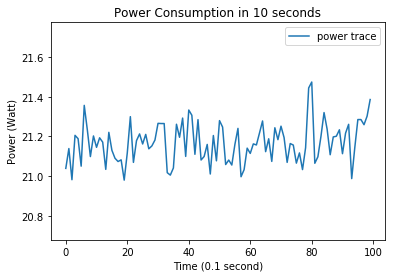

In [32]:
plt.figure()
plt.title("Power Consumption in 10 seconds")
plt.ylabel("Power (Watt)")
plt.xlabel("Time (0.1 second)")
plt.ylim(ymax=max(power_trace)+0.3,ymin=min(power_trace)-0.3)
plt.plot(power_trace, label="power trace")
plt.legend()
plt.show()

#### From this prototype, we can see that polling at 10Hz is not a heavy load operation on the host, and also we know the range and variation which is important to the GUI guy.

In [33]:
hal.close(device_name)

### The way I am using it

* Debug interactively (kernel hang, memory mis-alignment and other ugly bugs)
* Prototype host code (rapid prototyping) For example, quickly write up a power profiling and see if the plot make sense.
* Presentation (notebook)